# <b>Regression with a Tabular Paris Housing Price Dataset</b>

In [2]:
# !pip install catboost

## 1. Import Libraries

In [3]:
import numpy as np
import pandas as pd
import random
import os
import time

# Scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# ML model
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import skew

import warnings
warnings.filterwarnings('ignore')

### 1-1. Fixed Seed

In [4]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## 2. Load Data
`train.csv`: 학습 데이터, 타겟: price<br>
`test.csv`: 테스트 데이터 <br>

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### 2-1. 데이터 설명

In [6]:
def data_describe(df, title):
    print(f'====================== {title} Data Describe ======================')
    print(f'Row: {df.shape[0]}, Column: {df.shape[1]}')
    columns = df.columns
    data_type = []

    for col in columns:
        data_type.append(df[col].dtype)

    n_uniq = df.nunique()
    n_miss = df.isna().sum()

    names = list(zip(columns, data_type, n_uniq, n_miss))
    variable_desc = pd.DataFrame(names, columns=['Column', 'Dtype', 'Unique levels', 'Missing Count'])
    print(variable_desc)

In [7]:
data_describe(train, 'Train')

====================== Train Data Describe ======================
Row: 22730, Column: 18
               Column    Dtype  Unique levels  Missing Count
0                  id    int64          22730              0
1        squareMeters    int64           7319              0
2       numberOfRooms    int64            100              0
3             hasYard    int64              2              0
4             hasPool    int64              2              0
5              floors    int64            101              0
6            cityCode    int64           7810              0
7       cityPartRange    int64             10              0
8       numPrevOwners    int64             10              0
9                made    int64             33              0
10         isNewBuilt    int64              2              0
11  hasStormProtector    int64              2              0
12           basement    int64           4903              0
13              attic    int64           5167            

In [8]:
data_describe(test, 'Test')

====================== Test Data Describe ======================
Row: 15154, Column: 17
               Column  Dtype  Unique levels  Missing Count
0                  id  int64          15154              0
1        squareMeters  int64           6433              0
2       numberOfRooms  int64            100              0
3             hasYard  int64              2              0
4             hasPool  int64              2              0
5              floors  int64            100              0
6            cityCode  int64           6632              0
7       cityPartRange  int64             10              0
8       numPrevOwners  int64             10              0
9                made  int64             32              0
10         isNewBuilt  int64              2              0
11  hasStormProtector  int64              2              0
12           basement  int64           4216              0
13              attic  int64           4558              0
14             garage  int6

## 3. EDA & Preprocessing

In [9]:
num_cols = ['squareMeters','numberOfRooms','floors','cityPartRange','numPrevOwners',
            'made','basement','attic','garage','hasGuestRoom','cityCode']
cat_cols = ['hasYard','hasPool','isNewBuilt','hasStormProtector','hasStorageRoom']
drop_col = ['id']

train.drop(drop_col, axis=1, inplace=True)
test.drop(drop_col, axis=1, inplace=True)

### 3-1. One-Hot Encoding

In [10]:
num_imp = SimpleImputer(strategy='mean')
cat_imp = SimpleImputer(strategy='most_frequent')

ohe = OneHotEncoder(handle_unknown='ignore',sparse = False,drop="first")

train[num_cols] = pd.DataFrame(num_imp.fit_transform(train[num_cols]), columns=num_cols)
train[cat_cols] = pd.DataFrame(cat_imp.fit_transform(train[cat_cols]), columns=cat_cols)
train_temp = pd.DataFrame(ohe.fit_transform(train[cat_cols]), columns=ohe.get_feature_names_out())
train = pd.concat([train.drop(cat_cols, axis=1), train_temp], axis=1)

test[num_cols] = pd.DataFrame(num_imp.transform(test[num_cols]),columns=num_cols)
test[cat_cols] = pd.DataFrame(cat_imp.transform(test[cat_cols]),columns=cat_cols)
test_temp = pd.DataFrame(ohe.transform(test[cat_cols]), columns=ohe.get_feature_names_out())
test = pd.concat([test.drop(cat_cols, axis=1), test_temp], axis=1)

In [11]:
X = train.drop(['price'], axis=1)
y = train['price']

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

### 3-2. 이상치 제거

squareMeters
Rejection 1 points


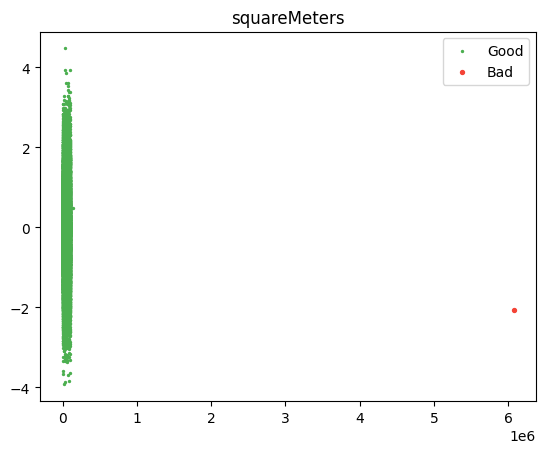

In [12]:
num_cols_outl = ['squareMeters']
cont_FEATURES = num_cols_outl

def plot_outliers(data, target, df, feature, threshold=8):
    mean, std = np.mean(df), np.std(df)
    z_score = np.abs((df-mean) / std)
    good = z_score < threshold
    print(f"Rejection {(~good).sum()} points")
    visual_scatter = np.random.normal(size=df.size)
    plt.scatter(df[good], visual_scatter[good], s=2, label="Good", color="#4CAF50")
    plt.scatter(df[~good], visual_scatter[~good], s=8, label="Bad", color="#F44336")
    plt.legend(loc='upper right')
    plt.title(feature)
    plt.show();

    data, target = data[good], target[good]

    return data,target

for feature in cont_FEATURES:
    print(feature)
    X, y = plot_outliers(X, y, X[feature], feature)

In [13]:
# 이상치 제거
indexies = X[X['squareMeters']>99999].index
X = X.drop(indexies).reset_index(drop=True)
y = y.drop(indexies).reset_index(drop=True)

### 3-3. Feature Engineering

In [14]:
X['floors'] = X['floors'].apply(lambda x: x if x<1000 else train['floors'].mean())
X['made'] = X['made'].apply(lambda x: x if x<2022 else train['made'].mean())

X['basement'] = X['basement'].apply(lambda x: x if x<=10000 else train['basement'].mean())
test['basement'] = test['basement'].apply(lambda x: x if x<=10000 else train['basement'].mean())

X['attic'] = X['attic'].apply(lambda x: x if x<=10000 else train['attic'].mean())
test['attic'] = test['attic'].apply(lambda x: x if x<=10000 else train['attic'].mean())

X['garage'] = X['garage'].apply(lambda x: x if x<=1000 else train['garage'].mean())

X['cityCode'] = X['cityCode'].apply(lambda x: x if x<=100000 else int(train['cityCode'].mean()))
test['cityCode'] = test['cityCode'].apply(lambda x: x if x<=100000 else int(train['cityCode'].mean()))

X['points'] = X['hasYard_1'] + X['hasPool_1'] + X['isNewBuilt_1'] + X['hasStormProtector_1'] + X['hasStorageRoom_1']
X.drop(['hasYard_1','hasPool_1','isNewBuilt_1','hasStormProtector_1','hasStorageRoom_1'], axis=1, inplace=True)

test['points'] = test['hasYard_1'] + test['hasPool_1'] + test['isNewBuilt_1'] + test['hasStormProtector_1'] + test['hasStorageRoom_1']
test.drop(['hasYard_1','hasPool_1','isNewBuilt_1','hasStormProtector_1','hasStorageRoom_1'], axis=1, inplace=True)

In [15]:
def viz_comp(data1, data2, title):
    n_bins = 50
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    cols = num_cols
    fig, ax = plt.subplots(len(cols)//3+1, 3, figsize=(20, 20))
    ax = ax.flatten()

    for i, column in enumerate(cols):
        sns.histplot(
            data1[column], label='Train',
            ax=ax[i], color='green', **histplot_hyperparams)

    for i, column in enumerate(cols):
        sns.histplot(
            data2[column], label='Test',
            ax=ax[i], color='red', **histplot_hyperparams)

    fig.suptitle(title, position = (0.5, 1.01), fontstyle='normal', size=25)
    fig.legend(['train', 'test'], bbox_to_anchor=(0.65, 1.01), fontsize=11, title_fontsize=12)
    fig.tight_layout()
    plt.show()

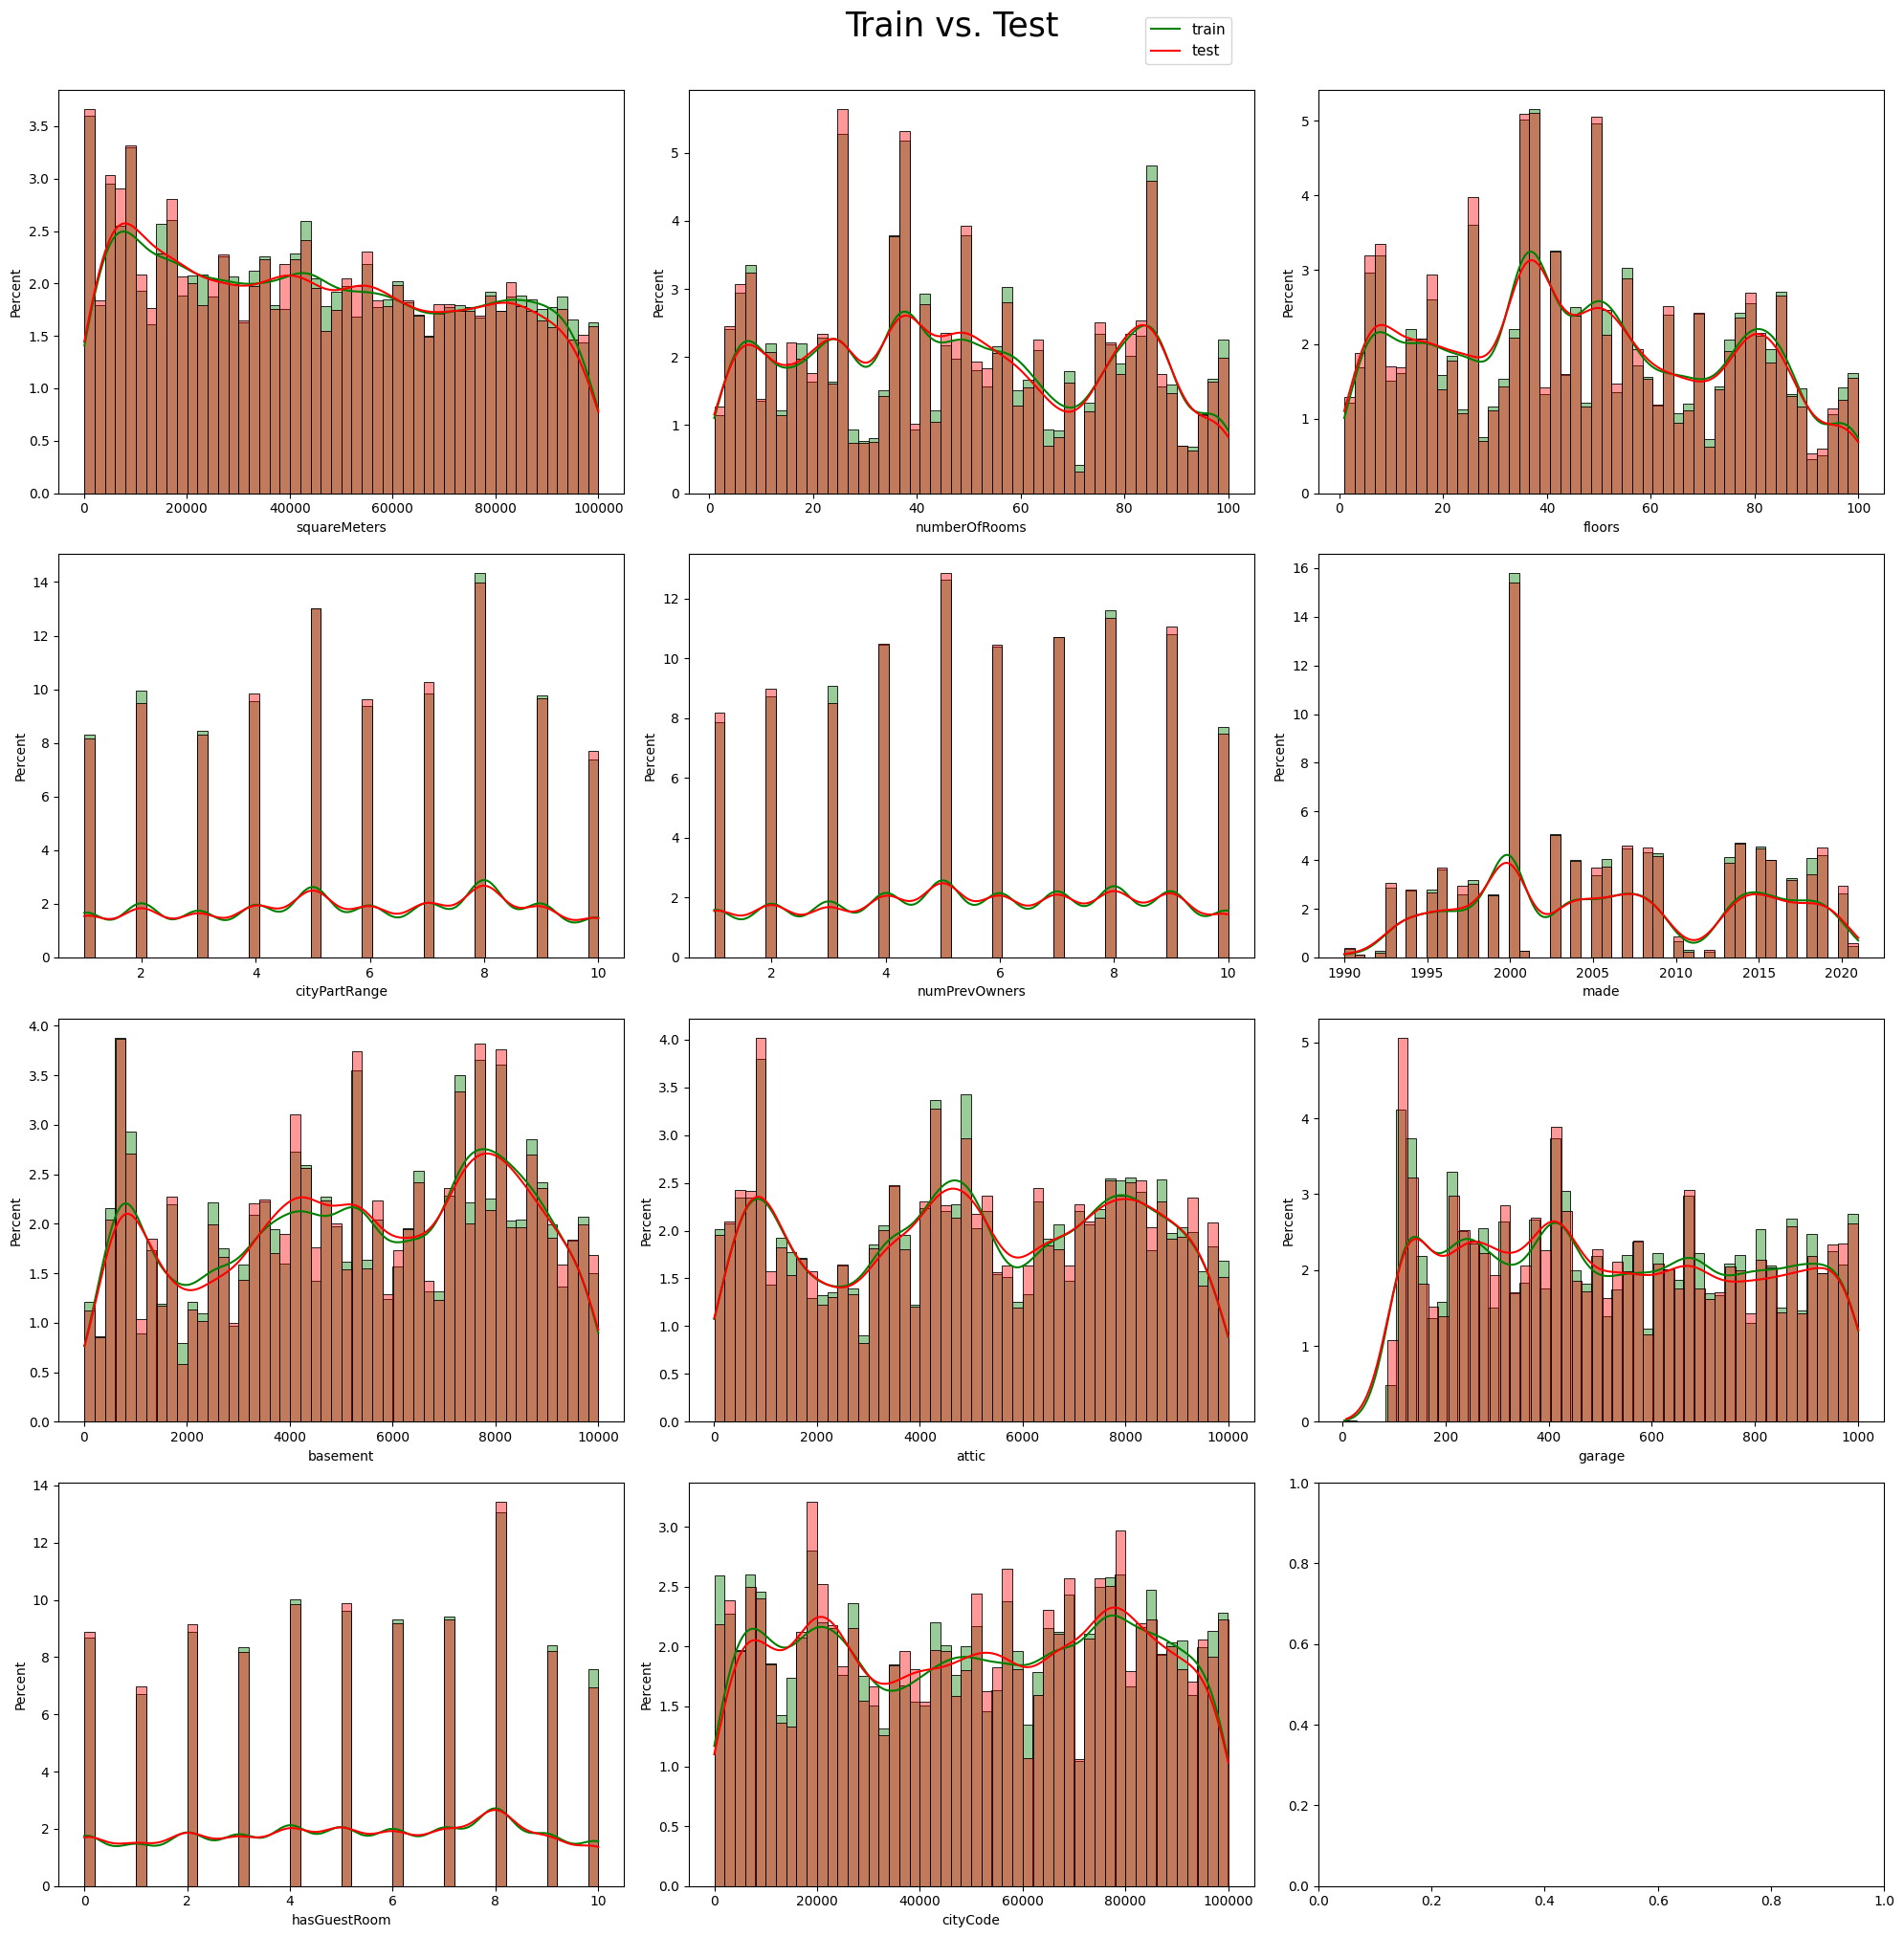

In [16]:
viz_comp(X, test, 'Train vs. Test')

In [17]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

### 3-4. StandardScaler(표준화)

In [18]:
for n in train.columns:
    print(str(round(skew(train[n]), 3)) +" = "+ n)

79.248 = squareMeters
0.115 = numberOfRooms
85.117 = floors
0.246 = cityCode
-0.093 = cityPartRange
-0.077 = numPrevOwners
66.93 = made
3.336 = basement
2.81 = attic
1.379 = garage
-0.118 = hasGuestRoom
0.131 = price
0.097 = hasYard_1
0.19 = hasPool_1
0.128 = isNewBuilt_1
0.16 = hasStormProtector_1
0.154 = hasStorageRoom_1


In [19]:
scaler = StandardScaler()
X[num_cols] = pd.DataFrame(data = scaler.fit_transform(X[num_cols]),columns = X[num_cols].columns)
test[num_cols] = pd.DataFrame(data = scaler.transform(test[num_cols]),columns = test[num_cols].columns)

## 4. Train Model
- 평가지표: `Root Mean Squared Error(RMSE)`

In [20]:
# Consolidation
models = {}
preds_val = {}
preds_test = {}

# X for modelling
X_model = X.copy()
test_model = test.copy()
y_model = y.copy()

In [21]:
n_splits = 5
n_repeats = 10
cv = RepeatedKFold(n_splits=n_splits, n_repeats = n_repeats, random_state=42)

### 4-1. Train XGBoost Model

In [22]:
model_name = 'XGB'

XGB_drop_list = ['numPrevOwners', 'floors']

X = X_model.drop(XGB_drop_list, axis=1)
test = test_model.drop(XGB_drop_list, axis=1)
y = y_model

In [23]:
xgb_params= {
    'n_estimators': 3370,
    'early_stopping_rounds': 200}

In [24]:
results = []
for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    j = i//n_splits
    start_time = time.time()

    train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
    train_y, valid_y = y.iloc[train_index], y.iloc[test_index]

    model = xgb.XGBRegressor(**xgb_params).fit(train_X, train_y,
                                               eval_set=[(train_X, train_y), (valid_X, valid_y)],
                                               verbose=0)

    models[f'{model_name}_{i}_{j}'] = (model)
    preds_val[f'{model_name}_{i}_{j}'] = (model.predict(valid_X))
    preds_test[f'{model_name}_{i}_{j}'] = (model.predict(test))

    result = np.sqrt(mean_squared_error(valid_y, model.predict(valid_X)))
    results.append(result)
    print('|Step %2d| %10.4fs sec| Auc Result: %15.4f|' % (i, time.time() - start_time, result))
print(f'Final XGB Result: {sum(results)/len(results)}')

|Step  0|    19.4052s sec| Auc Result:     209281.7467|
|Step  2|     4.8576s sec| Auc Result:      93744.8320|
|Step  3|     2.9772s sec| Auc Result:     119980.2103|
|Step  4|     3.0585s sec| Auc Result:     173723.5191|
|Step  5|     4.7640s sec| Auc Result:     166880.7102|
|Step  6|     3.0128s sec| Auc Result:     166979.4852|
|Step  7|     3.0500s sec| Auc Result:     178782.1658|
|Step  8|     3.0814s sec| Auc Result:     134338.3494|
|Step  9|     4.9794s sec| Auc Result:     131811.0824|
|Step 10|     3.0930s sec| Auc Result:     197100.9952|
|Step 11|     3.0978s sec| Auc Result:     164478.8280|
|Step 12|     4.8813s sec| Auc Result:     177829.7046|
|Step 13|     3.1019s sec| Auc Result:      39354.5321|
|Step 14|     3.3554s sec| Auc Result:     100043.9378|
|Step 15|    21.7784s sec| Auc Result:     116760.4368|
|Step 16|     3.0148s sec| Auc Result:     198636.2111|
|Step 17|     5.2645s sec| Auc Result:     134424.5848|
|Step 18|     3.2061s sec| Auc Result:     10718

### 4-2. Train GatBoost Model

In [25]:
model_name = 'CAT'

CAT_drop_list = ['numberOfRooms']

X = X_model.drop(CAT_drop_list, axis=1)
test = test_model.drop(CAT_drop_list, axis=1)
y = y_model

In [26]:
cat_params={'eval_metric': 'RMSE',
            'rsm': 0.8612419654237979,
            'use_best_model': True,
            'iterations': 3012,
            'learning_rate': 0.04989902557803795,
            'depth': 7,
            'l2_leaf_reg': 27.909332711608926,
            'bootstrap_type': 'Bayesian',
            'random_strength': 1.9029390626401702e-05,
            'bagging_temperature': 0.19703737765580503,
            'od_type': 'Iter',
            'od_wait': 200}

In [27]:
results = []
for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    j = i//n_splits
    start_time = time.time()

    train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
    train_y, valid_y = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostRegressor(**cat_params).fit(train_X, train_y,
                                                eval_set=[(valid_X, valid_y)],
                                                verbose=0)

    models[f'{model_name}_{i}_{j}'] = (model)
    preds_val[f'{model_name}_{i}_{j}'] = (model.predict(valid_X))
    preds_test[f'{model_name}_{i}_{j}'] = (model.predict(test))

    result = np.sqrt(mean_squared_error(valid_y, model.predict(valid_X)))
    results.append(result)
    print('|Step %2d| %10.4fs sec| Auc Result: %15.4f|' % (i, time.time() - start_time, result))
print(f'Final CAT Result: {sum(results)/len(results)}')

|Step  0|    10.1442s sec| Auc Result:     194074.1407|
|Step  1|     2.1496s sec| Auc Result:     174207.6322|
|Step  2|    11.8722s sec| Auc Result:     112336.8874|
|Step  3|     9.6972s sec| Auc Result:      62366.2439|
|Step  4|     9.2881s sec| Auc Result:     169184.4342|
|Step  5|     2.4742s sec| Auc Result:     133276.6634|
|Step  6|     5.3759s sec| Auc Result:     147685.8094|
|Step  7|     4.1421s sec| Auc Result:     185272.9428|
|Step  8|     2.3437s sec| Auc Result:     145448.3508|
|Step  9|     3.8711s sec| Auc Result:     138822.7452|
|Step 10|     8.0182s sec| Auc Result:     188729.6751|
|Step 11|     7.1520s sec| Auc Result:     179066.6850|
|Step 12|     8.7492s sec| Auc Result:     174786.2529|
|Step 13|     7.5766s sec| Auc Result:      38517.0986|
|Step 14|    10.7581s sec| Auc Result:      93787.0745|
|Step 15|     7.8518s sec| Auc Result:     120757.3953|
|Step 16|    11.8985s sec| Auc Result:     196325.0593|
|Step 17|     2.0766s sec| Auc Result:     13984

### 4-3. Train RandomForestRegressor Model

In [28]:
model_name = 'RF'

RF_drop_list = ['hasGuestRoom', 'attic', 'basement', 'points', 'garage']

X = X_model.drop(RF_drop_list, axis=1)
test = test_model.drop(RF_drop_list, axis=1)
y = y_model

In [29]:
rf_params = {'n_estimators': 145,
             'n_jobs': -1,
             'verbose': 0,
             'min_samples_split': 2,
             'min_samples_leaf': 2}

In [30]:
results = []
for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    j = i//n_splits
    start_time = time.time()

    train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
    train_y, valid_y = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestRegressor(**rf_params).fit(train_X, train_y)

    models[f'{model_name}_{i}_{j}'] = (model)
    preds_val[f'{model_name}_{i}_{j}'] = (model.predict(valid_X))
    preds_test[f'{model_name}_{i}_{j}'] = (model.predict(test))

    result = np.sqrt(mean_squared_error(valid_y, model.predict(valid_X)))
    results.append(result)
    print('|Step %2d| %10.4fs sec| Auc Result: %15.4f|' % (i, time.time() - start_time, result))
print(f'Final RF Result: {sum(results)/len(results)}')

|Step  0|     5.3695s sec| Auc Result:     199789.5362|
|Step  1|     6.6896s sec| Auc Result:     171652.6624|
|Step  2|     7.9406s sec| Auc Result:      97020.6046|
|Step  3|     6.7962s sec| Auc Result:     139756.1688|
|Step  4|     7.7454s sec| Auc Result:     172619.2373|
|Step  5|     6.0924s sec| Auc Result:     181001.5004|
|Step  6|     5.2727s sec| Auc Result:     157887.9798|
|Step  7|     6.6477s sec| Auc Result:     186960.2884|
|Step  8|     5.3374s sec| Auc Result:     141555.2258|
|Step  9|     6.7579s sec| Auc Result:     145259.2692|
|Step 10|     5.2336s sec| Auc Result:     191969.4330|
|Step 11|     6.7430s sec| Auc Result:     177163.3892|
|Step 12|     5.2604s sec| Auc Result:     185842.2168|
|Step 13|     6.4144s sec| Auc Result:      85974.5208|
|Step 14|     5.4632s sec| Auc Result:     128130.2944|
|Step 15|     5.3590s sec| Auc Result:     134539.3162|
|Step 16|     6.4198s sec| Auc Result:     204566.0967|
|Step 17|     5.2009s sec| Auc Result:     16483

## 5. Ensemble: Stacking

In [31]:
for n in preds_val:
    preds_val[n] = np.rint(preds_val[n])

In [32]:
stack_preds = []
key_model = list(preds_val.keys())[0].split("_")[0]
key_last = list(preds_val.keys())[-1]

for step_model in np.arange(0, n_repeats, 1):
    key_model = list(preds_val.keys())[0].split("_")[0]
    temp_0 = pd.DataFrame()
    temp_1 = pd.DataFrame()
    for step_pred in preds_val:
        key = int(step_pred.split("_")[2])
        if key == step_model and step_pred.split("_")[0] == key_model:
            temp_1 = pd.concat([temp_1, pd.DataFrame(preds_val[step_pred])], axis=0)
        else:
            if key != step_model:
                next
            else:
                temp_0 = pd.concat([temp_0, temp_1], axis=1)
                key_model = step_pred.split("_")[0]
                temp_1 = pd.DataFrame()
                temp_1 = pd.concat([temp_1, pd.DataFrame(preds_val[step_pred])], axis=0)
    if step_pred == key_last:
        temp_0 = pd.concat([temp_0, temp_1], axis=1)

    stack_preds.append(temp_0.reset_index(drop=True))

In [33]:
for n in preds_test:
    preds_test[n] = np.rint(preds_test[n])

In [34]:
stack_tests = []
key_model = list(preds_test.keys())[0].split("_")[0]
key_last = list(preds_test.keys())[-1]

for step_model in np.arange(0, n_repeats, 1):
    key_model = list(preds_test.keys())[0].split("_")[0]
    temp_0 = pd.DataFrame()
    temp_1 = pd.DataFrame()
    for step_pred in preds_test:
        key = int(step_pred.split("_")[2])
        if key == step_model and step_pred.split("_")[0] == key_model:
            temp_1 = pd.concat([temp_1, pd.DataFrame(preds_test[step_pred])], axis=1)
        else:
            if key != step_model:
                next
            else:
                temp_1 = temp_1.mean(axis=1)
                temp_0 = pd.concat([temp_0,temp_1],axis=1)

                key_model = step_pred.split("_")[0]
                temp_1 = pd.DataFrame()
                temp_1 = pd.concat([temp_1, pd.DataFrame(preds_test[step_pred])], axis=1)
    if step_pred == key_last:
        temp_1 = temp_1.mean(axis=1)
        temp_0 = pd.concat([temp_0,temp_1],axis=1)

    stack_tests.append(temp_0.reset_index(drop=True))

In [35]:
stack_targets = []
for step_model in np.arange(0, n_repeats, 1):
    temp = pd.DataFrame()
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        key = i//n_splits
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        if step_model == key:
            temp = pd.concat([temp, pd.DataFrame(valid_y)], axis=0)
    stack_targets.append(temp.reset_index(drop=True))

In [36]:
lgb_params = {'early_stopping_round':100,
              'n_estimators':5000}

In [37]:
results = []
predicts = pd.DataFrame()

for step_model in np.arange(0, n_repeats, 1):
    print(f'STEP: {step_model}')
    X_stack = stack_preds[step_model].to_numpy()
    test_stack = stack_tests[step_model].to_numpy()
    y_stack = stack_targets[step_model].to_numpy()

    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        temp = pd.DataFrame()
        start_time = time.time()

        train_X, valid_X = X_stack[train_index], X_stack[test_index]
        train_y, valid_y = y_stack[train_index], y_stack[test_index]
        model = lgb.LGBMRegressor(**lgb_params).fit(train_X, train_y,
                                                    eval_set=[(valid_X, valid_y)],
                                                    callbacks=[lgb.log_evaluation(period=0, show_stdv=False)])

        result = np.sqrt(mean_squared_error(valid_y,(model.predict(valid_X))))
        results.append(result)
        print('|Step %2d| %10.4fs sec| Auc Result: %15.4f|' % (i, time.time() - start_time, result))

        predict = model.predict(test_stack)
        temp[i]=predict
    predicts[step_model]=temp.mean(axis=1)

print(f'Final LGB Result: {sum(results)/len(results)}')

STEP: 0
|Step  0|     0.2364s sec| Auc Result:     168547.8896|
|Step  1|     0.2770s sec| Auc Result:     198901.5846|
|Step  2|     0.1961s sec| Auc Result:      92441.8549|
|Step  3|     0.1972s sec| Auc Result:      74058.0749|
|Step  4|     0.2145s sec| Auc Result:     147205.6855|
|Step  5|     0.5661s sec| Auc Result:     211471.1178|
|Step  6|     2.1110s sec| Auc Result:     163948.9328|
|Step  7|     0.1960s sec| Auc Result:      89093.5713|
|Step  8|     0.1984s sec| Auc Result:      66886.0778|
|Step  9|     0.1912s sec| Auc Result:     141414.7152|
|Step 10|     1.7729s sec| Auc Result:     136310.7236|
|Step 11|     0.1817s sec| Auc Result:     139952.6794|
|Step 12|     0.1877s sec| Auc Result:     173919.5211|
|Step 13|     0.7235s sec| Auc Result:     173174.3295|
|Step 14|     0.2062s sec| Auc Result:      72168.4639|
|Step 15|     0.2017s sec| Auc Result:     204715.9142|
|Step 16|     0.1881s sec| Auc Result:     133754.9582|
|Step 17|     0.1730s sec| Auc Result:  

## 6. Submission

In [38]:
submission = pd.read_csv('sample_submission.csv')

In [39]:
submission['price'] = predicts.mean(axis=1)
submission.to_csv(f'submission.csv', index=False)

In [40]:
submission.head()

,id,price
0,22730,4.763039e+06
1,22731,6.207075e+06
2,22732,9.041446e+06
3,22733,1.640742e+06
4,22734,6.756010e+06
